In [1]:
%matplotlib inline

from __future__ import print_function, division

import os, sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from ipywidgets import interact, interactive, interact_manual
from ipywidgets import FloatSlider, IntSlider, Dropdown
from ipywidgets import Checkbox, RadioButtons, fixed 

from IPython.display import display, Math, clear_output

from astropy.convolution import convolve, Gaussian1DKernel

import seaborn as sns
sns.set(context="poster", font_scale=1.5)

# from bokeh import mpl
# from bokeh.plotting import show, output_notebook
# output_notebook()


## import from local files

## Boilerplate path hack to give access to full SNe package
import sys
if __package__ is None:
    if os.pardir not in sys.path[0]:
        file_dir = os.getcwd()
        sys.path.insert(0, os.path.join(file_dir, 
                                        os.pardir, 
                                        os.pardir))

from SNe.analysis.constants import m_proton, pc, yr, M_solar, \
                                   gamma, E_0, metallicity_solar
    
from SNe.analysis.sedov.dimensionalize_sedov import dimensionalized_sedov
from SNe.analysis.sedov.closed_form_sedov import SedovSolution
from SNe.analysis.parameter_study_file_structure import make_dirname_from_properties
from SNe.analysis.parse import RunSummary, Overview, parse_run, cols


general_string_format = ".2e"

from SNe.analysis.visualize_helpers import plotter, single_run, \
                                           conduction_comparisons, \
                                           parameter_study_wrapper, \
                                           SNe_distplot, \
                                           plot_zones, \
                                           plot_shock_location, \
                                           plot_energy, \
                                           plot_momentum, \
                                           plot_luminosity



        
# Holds the most recent run, if more analysis is desired
last_run = RunSummary()    

/Users/egentry/anaconda/lib/python3.4/site-packages/IPython/kernel/__init__.py:13: ShimWarning: The `IPython.kernel` package has been deprecated. You should import from ipykernel or jupyter_client instead.
  "You should import from ipykernel or jupyter_client instead.", ShimWarning)


E_kin:  2.85e+50
E_int:  7.15e+50
checkpoint:  ../src/B1411D42-0C39-4A16-BD31-28CAD26B5C8D_checkpoint_0099.dat
time:                       5.02e+07 [yr] 	 1.58e+15 [s]
time elapsed:               4.23e+07 [yr] 	 1.34e+15 [s]
background_density:         2.22e-24
Cluster mass:               1.00e+02 M_sol
Number of SNe so far:       2
mass loss prescription:     uniform


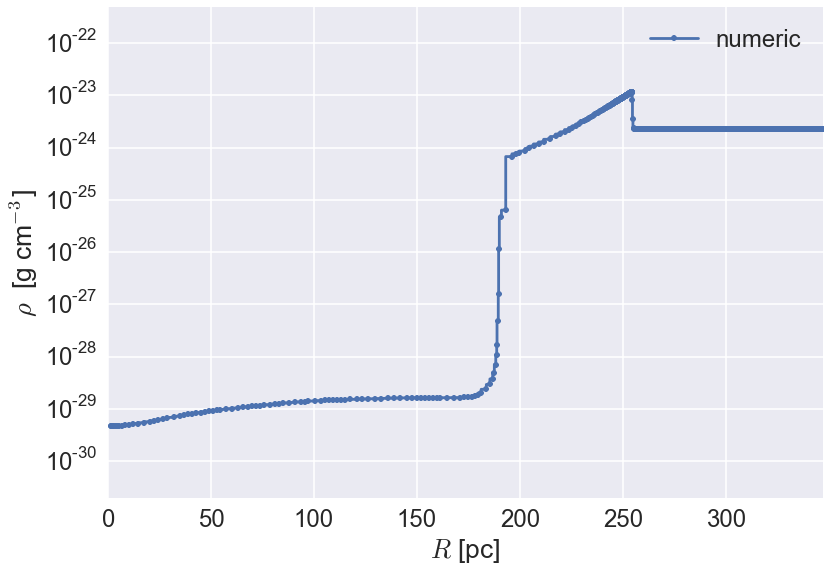

In [2]:
data_dir_default = "../src/"

# you don't need the full uuid, just enough to distinguish it
id_default = ""

# last_run = single_run(data_dir=data_dir_default, id=id_default)
result_widget = interact_manual(single_run,
                                data_dir = widgets.Text(data_dir_default),
                                id = widgets.Text(id_default))
def update_last_run_single_run(widget):
    """Copy the latest result into last_run
    
    Don't reuse this function definition; needs to be bound to the correct result_widget"""
    last_run.replace_with(result_widget.widget.result)
result_widget.widget.children[-1].on_click(update_last_run_single_run)

In [ ]:
data_dir = "../saved_runs/conduction/H_1"
H_0 = "H_0" in data_dir

M_cluster = 10**3* M_solar

conduction_comparisons(M_cluster, H_0, data_dir, num_SNe=2)


In [ ]:
data_dir = "../saved_runs/conduction/H_1"
H_0 = "H_0" in data_dir

M_clusters = np.array([1e2, 1e3, 1e4, 1e5]) * M_solar
for M_cluster in M_clusters:
    plt.close()
    clear_output()
    conduction_comparisons(M_cluster, H_0, data_dir, num_SNe=2)


In [3]:
result_widget_parameter_study = interact_manual(parameter_study_wrapper,
                                log_Z = FloatSlider(min=-3.0, max=+0.5, step=0.5, value=0),
                                log_n = FloatSlider(min=-3.0, max=+3.0, step=1.0, value=-1),
                                T     = fixed(1e4),
                                with_cooling = True)
def update_last_run_parameter_study(widget):
    """Copy the latest result into last_run
    
    Don't reuse this function definition; needs to be bound to the correct result_widget"""
    last_run.replace_with(result_widget_parameter_study.widget.result)
result_widget_parameter_study.widget.children[-1].on_click(update_last_run_parameter_study)


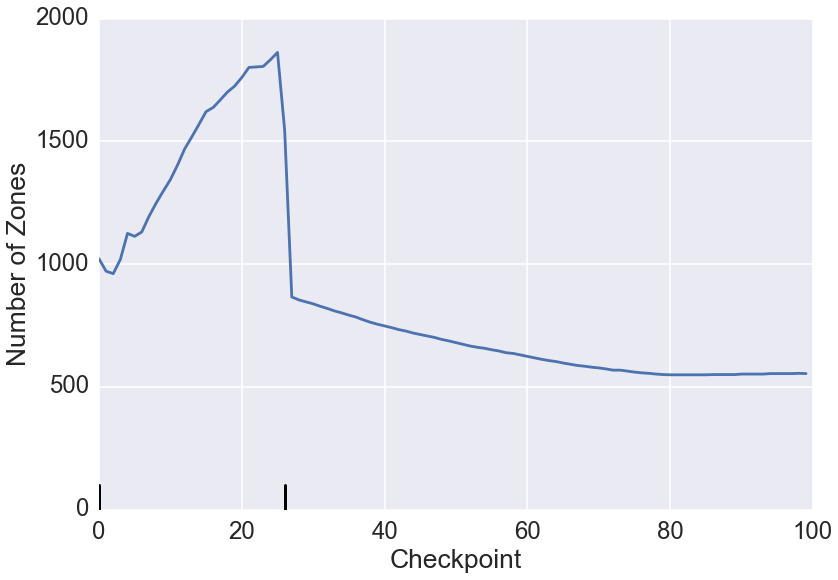

In [4]:
plot_zones(last_run)

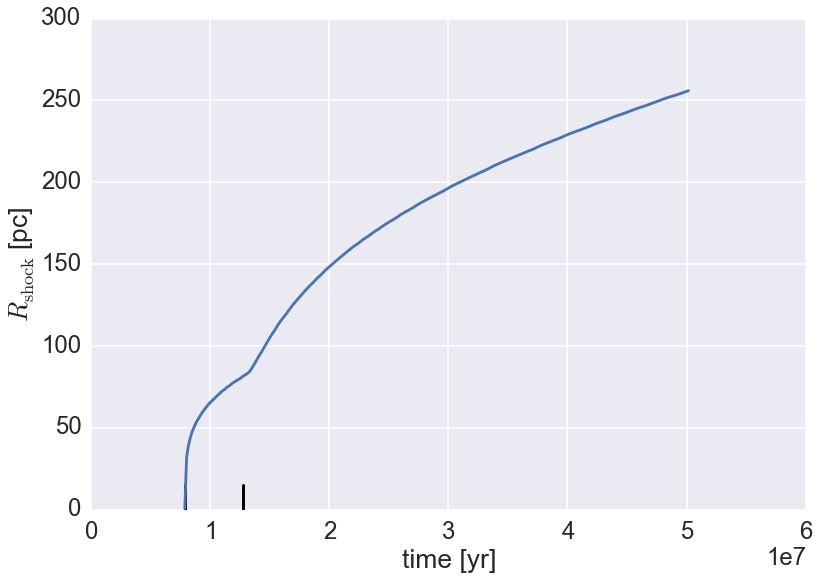

In [5]:
plot_shock_location(last_run)

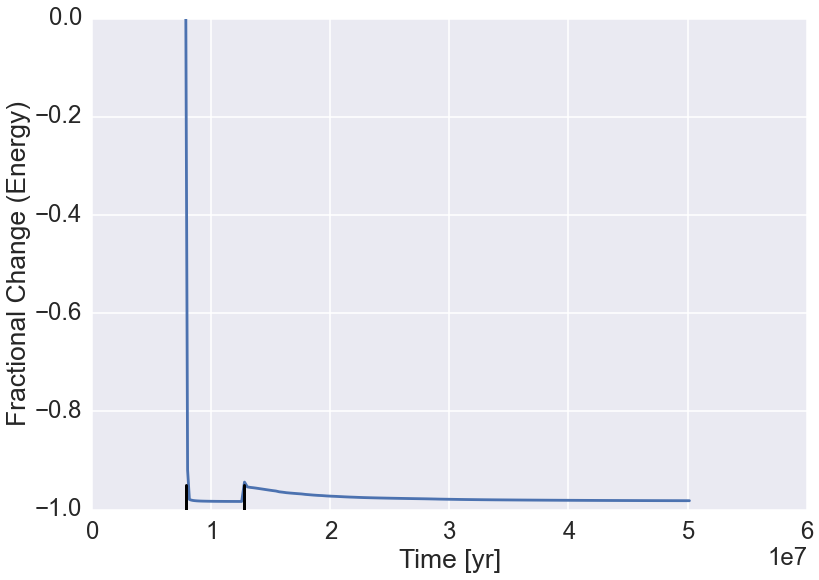

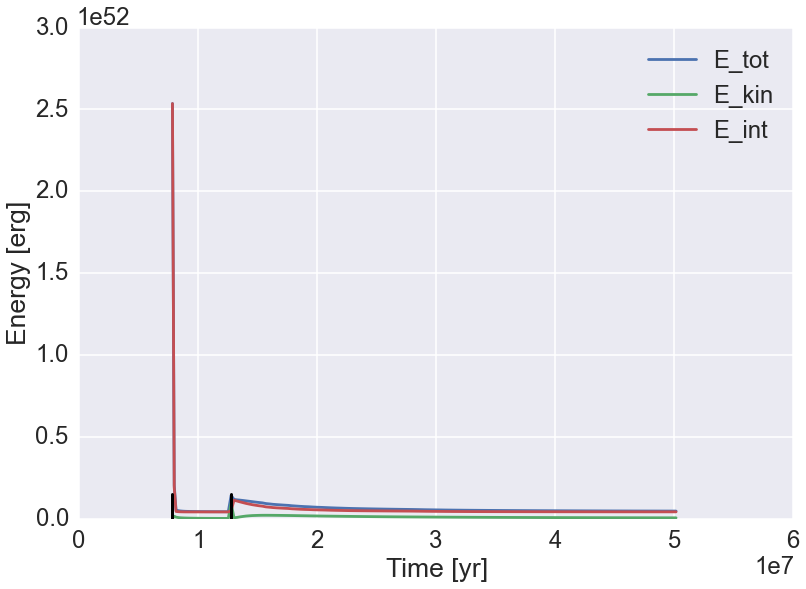

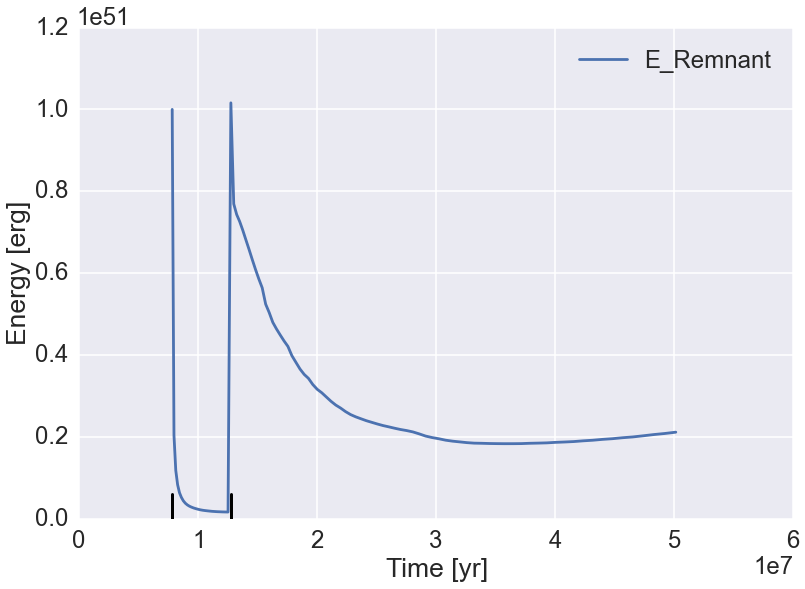

In [6]:
_ = interact(plot_energy,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]))

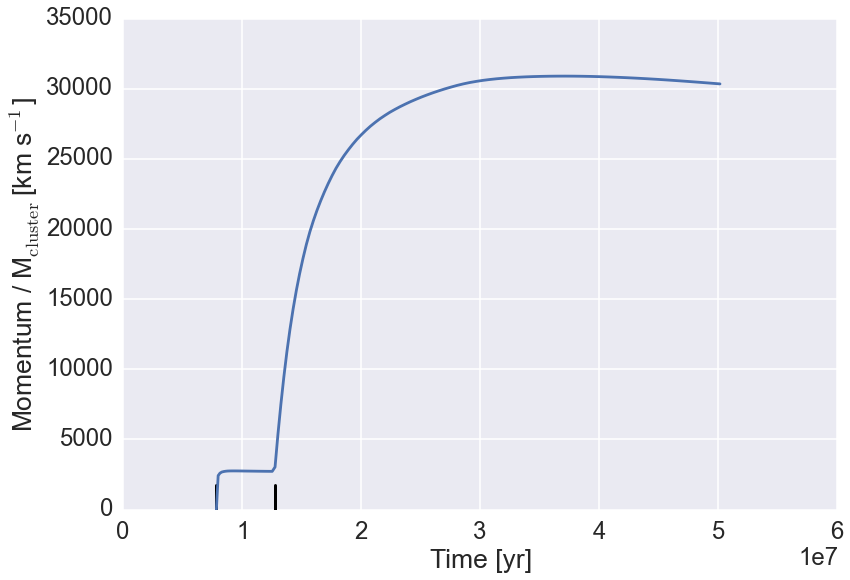

In [7]:
_ = interact(plot_momentum,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]),
         clear_previous=fixed(True),
         distplot=fixed(True))

Luminosity max at checkpoint:  1
Luminosity max at time:        8.00e+06 [yr]


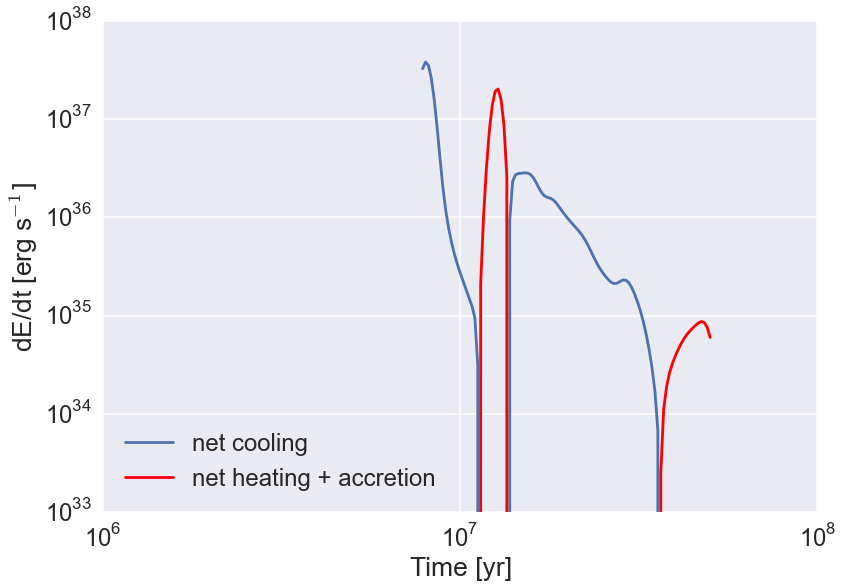

In [8]:
_ = interact(plot_luminosity,
         last_run=fixed(last_run),
         x_axis = RadioButtons(options=["time", "checkpoints"]))


In [ ]:
ids_1e2_M_solar = ["2177f", "0590d", "639be"]
ids_1e3_M_solar = ["7247a", "ff5b5", "de6b1"]
ids_1e4_M_solar = ["30faf", "cccbd", "c390f"]
ids_1e5_M_solar = ["2bf32", "46aed", "fa9c8"]

mass_loss_label_map = {"uniform"   : "constant",
                       "disappear" : "disappear",
                       "none"      : r"$\mathtt{AGORA}$"}

data_dir = "../src"

def mass_loss_comparisons_last_checkpoint(ids, data_dir="../src"):
    
    if not os.path.exists(data_dir):
        raise FileNotFoundError("No directory found named: "+ data_dir)
        
    plt.figure()
    mass_loss_labels = []
    
    for id in ids:
    
        last_run, parse_results = parse_run(data_dir, id)
        sedov_solution = SedovSolution(E_0,
                                       last_run["overview"].background_density, 
                                       last_run["overview"].metallicity)

        #### PASS TO PLOTTER ####
        num_checkpoints = len(parse_results.checkpoint_filenames)

        log_R_max = round(np.log10(last_run["df"]["Radius"].max()), 2)
        log_R_min = max(log_R_max-4, 
                        round(np.log10(last_run["df"]["Radius"].min()), 2)+1)


        plt.title("{0:.0e}".format(last_run["overview"].cluster_mass / M_solar) + r" $M_\odot$ cluster" )

        plotter(last_run,
                parse_results.checkpoint_filenames, 
                last_run["overview"].metallicity, 
                last_run["overview"].background_density, 
                last_run["overview"].background_temperature,
                sedov_solution,
                x_axis_variable  = "Radius",
                y_axis_variable  = "Density",
                with_Sedov       = False,
                highlight_timestep_limiting_cell = False,
                outer_limit_log  = log_R_max, 
                checkpoint_index = num_checkpoints-1,
                show_at_end = False)
        mass_loss_labels.append(mass_loss_label_map[last_run["overview"].mass_loss])


    plt.legend(mass_loss_labels, loc="best", title="mass loss")
    plt.setp(plt.gca().get_legend().get_title(),
             fontsize=plt.rcParams["legend.fontsize"])

    plot_filename = "plots/last_checkpoint_{0:.0e}_Msun".format(last_run["overview"].cluster_mass / M_solar)
    plt.savefig(plot_filename + ".eps")
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    clear_output()
#     plt.close()

def mass_loss_comparisons_before_second_blast(ids, data_dir="../src"):
    
    if not os.path.exists(data_dir):
        raise FileNotFoundError("No directory found named: "+ data_dir)
        
    plt.figure()
    mass_loss_labels = []
    
    for id in ids:
    
        last_run, parse_results = parse_run(data_dir, id)
        sedov_solution = SedovSolution(E_0,
                                       last_run["overview"].background_density, 
                                       last_run["overview"].metallicity)

        #### PASS TO PLOTTER ####
        num_checkpoints = len(parse_results.checkpoint_filenames)
        plot_checkpoint = np.argmin(last_run["times"] < last_run["overview"].SNe_times[1]) - 1

        log_R_max = round(np.log10(last_run["df"]["Radius"].max()), 2)
        log_R_min = max(log_R_max-4, 
                        round(np.log10(last_run["df"]["Radius"].min()), 2)+1)


        plt.title("{0:.0e}".format(last_run["overview"].cluster_mass / M_solar) + r" $M_\odot$ cluster" )

        plotter(last_run,
                parse_results.checkpoint_filenames, 
                last_run["overview"].metallicity, 
                last_run["overview"].background_density, 
                last_run["overview"].background_temperature,
                sedov_solution,
                x_axis_variable  = "Radius",
                y_axis_variable  = "Density",
                with_Sedov       = False,
                highlight_timestep_limiting_cell = False,
                outer_limit_log  = log_R_max, 
                checkpoint_index = plot_checkpoint,
                show_at_end = False)
        mass_loss_labels.append(mass_loss_label_map[last_run["overview"].mass_loss])

    
    plt.legend(mass_loss_labels, loc="best", title="mass loss")
    plt.setp(plt.gca().get_legend().get_title(),
             fontsize=plt.rcParams["legend.fontsize"])

    plot_filename = "plots/before_second_blast_{0:.0e}_Msun".format(last_run["overview"].cluster_mass / M_solar)
    plt.savefig(plot_filename + ".eps")
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    clear_output()
#     plt.close()

def mass_loss_comparisons_momentum(ids, data_dir="../src"):
    
    if not os.path.exists(data_dir):
        raise FileNotFoundError("No directory found named: "+ data_dir)
    
    plt.figure()
    mass_loss_labels = []

    for id in ids:
    
        last_run, parse_results = parse_run(data_dir, id)
        sedov_solution = SedovSolution(E_0,
                                       last_run["overview"].background_density, 
                                       last_run["overview"].metallicity)

        #### PASS TO PLOTTER ####
        num_checkpoints = len(parse_results.checkpoint_filenames)

        log_R_max = round(np.log10(last_run["df"]["Radius"].max()), 2)
        log_R_min = max(log_R_max-4, 
                        round(np.log10(last_run["df"]["Radius"].min()), 2)+1)


        plt.title("{0:.0e}".format(last_run["overview"].cluster_mass / M_solar) + r" $M_\odot$ cluster" )
    
        plot_momentum(last_run, "time", clear_previous=False, distplot=False)
        mass_loss_labels.append(mass_loss_label_map[last_run["overview"].mass_loss])


    plt.legend(mass_loss_labels, loc="best", title="mass loss")
    plt.setp(plt.gca().get_legend().get_title(),
             fontsize=plt.rcParams["legend.fontsize"])
    
    SNe_distplot(last_run, "time")

    plot_filename = "plots/momentum_{0:.0e}_Msun".format(last_run["overview"].cluster_mass / M_solar)
    plt.savefig(plot_filename + ".eps")
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    clear_output()
#     plt.close()

    
    
def mass_loss_comparisons_R_shock(ids, data_dir="../src"):
    
    if not os.path.exists(data_dir):
        raise FileNotFoundError("No directory found named: "+ data_dir)
    
    plt.figure()
    mass_loss_labels = []
    
    for id in ids:
    
        last_run, parse_results = parse_run(data_dir, id)

        plt.title("{0:.0e}".format(last_run["overview"].cluster_mass / M_solar) + r" $M_\odot$ cluster" )
        shock_location_plot(last_run, clear_previous=False, distplot=False)
        mass_loss_labels.append(mass_loss_label_map[last_run["overview"].mass_loss])

    plt.legend(mass_loss_labels, loc="best", title="mass loss")
    plt.setp(plt.gca().get_legend().get_title(),
             fontsize=plt.rcParams["legend.fontsize"])
    
    SNe_distplot(last_run, "time")
    
    plot_filename = "plots/R_shock_{0:.0e}_Msun".format(last_run["overview"].cluster_mass / M_solar)
    plt.savefig(plot_filename + ".eps")
    plt.savefig(plot_filename + ".pdf")
    plt.savefig(plot_filename + ".png")
    clear_output()
#     plt.close()
    
    
    
plt.close()  
mass_loss_comparisons_before_second_blast(ids=ids_1e2_M_solar,
                                          data_dir=data_dir)

    
mass_loss_comparisons_last_checkpoint(ids_1e2_M_solar,
                                      data_dir=data_dir)
mass_loss_comparisons_last_checkpoint(ids_1e3_M_solar,
                                      data_dir=data_dir)
mass_loss_comparisons_last_checkpoint(ids_1e4_M_solar,
                                      data_dir=data_dir)
mass_loss_comparisons_last_checkpoint(ids_1e5_M_solar,
                                      data_dir=data_dir)

mass_loss_comparisons_momentum(ids_1e2_M_solar,
                               data_dir=data_dir)
mass_loss_comparisons_momentum(ids_1e3_M_solar,
                               data_dir=data_dir)
mass_loss_comparisons_momentum(ids_1e4_M_solar,
                               data_dir=data_dir)
mass_loss_comparisons_momentum(ids_1e5_M_solar,
                               data_dir=data_dir)

mass_loss_comparisons_R_shock(ids_1e2_M_solar,
                              data_dir=data_dir)
mass_loss_comparisons_R_shock(ids_1e3_M_solar,
                              data_dir=data_dir)
mass_loss_comparisons_R_shock(ids_1e4_M_solar,
                              data_dir=data_dir)
mass_loss_comparisons_R_shock(ids_1e5_M_solar,
                              data_dir=data_dir)


